In [16]:
import pandas as pd
import numpy as np
import warnings
import sys, os

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns

# Load track and computed summary statistics object and join them into a single data frame
tracks = pd.read_csv("../data/tracks_tagged_v6.csv")
summary = pd.read_parquet("tagger_v2/support/cache/tracks_tagged_v5.cache")
joined = tracks.merge(summary, on = "id_track", how = "inner")
print(joined.columns)

Index(['id_track', 'activity', 'type_m2_agg', 'valid', 'predict_activity',
       'predict_score', 'duration', 'max_speed', 'min_speed', 'avg_speed',
       'curviness', 'heading_mean', 'heading_std', 'turning_mean',
       'turning_std', 'distance_total', 'distance_o', 'detections',
       'p95_speed', 'p5_speed', 'med_speed', 'start_time', 'end_time'],
      dtype='object')


Only selects a subset of known activities for training.

In [7]:
act_list = [
    "transit", 
    "drifting", 
    "fishing", 
    "lobster",
    "hook", 
    "seine", 
    "trawl", 
    "stopped"
]

trainable = joined[joined["activity"].isin(act_list)]
# Further removes the "fishing" category since it is ambiguous
trainable = trainable[trainable["activity"] != "fishing"]
trainable["activity"].value_counts()

activity
stopped     1143
transit      867
drifting     191
lobster      153
hook         136
seine         37
trawl         35
Name: count, dtype: int64

Define the features and label encoding.

In [17]:
features_subset = ['p95_speed', 'p5_speed', 'med_speed',
       'curviness', 'heading_mean', 'heading_std', 'turning_mean',
       'turning_std', 'distance_total', 'distance_o']

X = trainable[features_subset]
y = trainable['activity']

# label encoding
type2num, num2type = {}, {}
num = 0
for type in y.unique():
    type2num[type] = num
    num2type[num] = type
    num += 1
y_numeric = y.map(type2num)
print(num2type)


{0: 'drifting', 1: 'hook', 2: 'transit', 3: 'seine', 4: 'stopped', 5: 'lobster', 6: 'trawl'}


In [27]:
# Train-test split (80:20), stratified sampling by vessel type
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.2, stratify=y_numeric, random_state=42)

# Address the class imbalance issues:
weights = class_weight.compute_sample_weight(class_weight="balanced", y = y_train)

# Define XGBoost model
model = xgb.XGBClassifier(
    objective='multi:softmax',  # Use 'multi:softprob' if you want probability outputs
    num_class=len(y.unique()),
    eval_metric='mlogloss',
    random_state=42
)

# Hyperparameter tuning (after a few tries)
param_grid = {
    'max_depth': [10, 12, 15],
    'learning_rate': [0.1, 0.05],
    'n_estimators': [350, 500]
}

# Perform 5-fold cross-validation with grid search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores
    verbose=1,
)


grid_search.fit(X_train, y_train, sample_weight = weights)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search.best_score_))
best_model = grid_search.best_estimator_

# Make predictions on test set
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print("\nTest Set Accuracy: {:.4f}".format(test_accuracy))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 500}
Best cross-validation accuracy: 0.9307

Test Set Accuracy: 0.9279


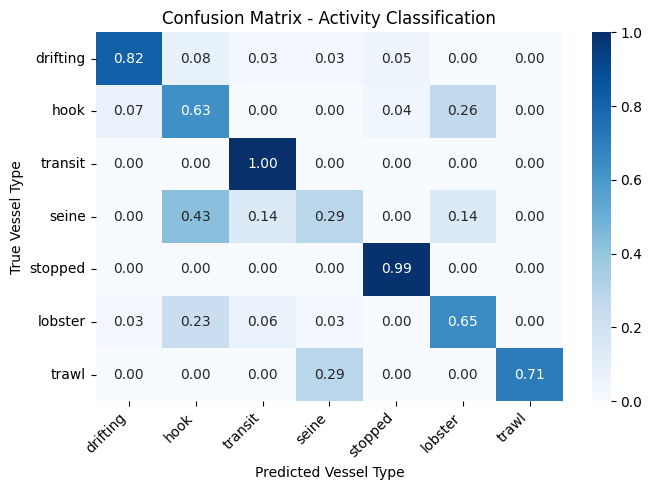

In [28]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm = cm / np.sum(cm, axis = 1, keepdims= True)

# Create a figure with a larger size
plt.figure(figsize=(7, 5))

# Create heatmap of confusion matrix
sns.heatmap(cm, 
            annot=True,  # Show numbers in cells
            fmt='.2f',     # Format as integers
            cmap='Blues',  # Use blue color scheme
            xticklabels=list(type2num.keys()),  # Use vessel type names for x-axis
            yticklabels=list(type2num.keys()))  # Use vessel type names for y-axis

# Customize the plot
plt.title('Confusion Matrix - Activity Classification')
plt.xlabel('Predicted Vessel Type')
plt.ylabel('True Vessel Type')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout()  # Adjust layout to prevent label cutoff

# Show the plot
plt.show()

In [29]:
num2type

{0: 'drifting',
 1: 'hook',
 2: 'transit',
 3: 'seine',
 4: 'stopped',
 5: 'lobster',
 6: 'trawl'}

In [30]:
import os
import joblib
import json

save_path = 'xgb_activity_model.pkl'
joblib.dump(best_model, save_path)

model_description = {
    "model_name": "XGBoost Vessel Activity Classifier",
    "features": features_subset,
    "params": grid_search.best_params_,
    "cv_accuracy": grid_search.best_score_,
    "test_accuracy": test_accuracy,
    "label_mapping": num2type,
    "notes": "Trained on summary statistics of vessel tracks. Stratified 80:20 split. 4-fold CV."
}

with open("xgb_activity_model_description.json", "w") as f:
    json.dump(model_description, f, indent=4)

print(f"Model and description saved.")

Model and description saved.
